In [1]:
import json
import numpy as np
import random
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Load the intents file
with open('intents.json') as file:
    data = json.load(file)

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Preprocess the data
def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens if w not in stop_words and w.isalnum()]
    return " ".join(tokens)

words = []
classes = []
documents = []

for intent in data['intents']:
    for pattern in intent['patterns']:
        pattern = preprocess_text(pattern)
        words.extend(pattern.split())
        documents.append((pattern, intent['tag']))
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

words = sorted(set(words))
classes = sorted(set(classes))

print("Classes:", classes)

# Create training data
training_sentences = []
training_labels = []

for doc in documents:
    training_sentences.append(doc[0])
    training_labels.append(classes.index(doc[1]))

# Tokenize the data
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(training_sentences)
X_train = tokenizer.texts_to_sequences(training_sentences)
X_train = pad_sequences(X_train)

y_train = np.array(training_labels)

# Build the model
model = Sequential()
model.add(Embedding(input_dim=2000, output_dim=128, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=150, batch_size=5, verbose=1)
model.save('chatbot_model.h5')

print("Model trained and saved")

# Load the model
model = tf.keras.models.load_model('chatbot_model.h5')

# Function to preprocess user input
def preprocess_user_input(sentence):
    sentence = preprocess_text(sentence)
    seq = tokenizer.texts_to_sequences([sentence])
    padded = pad_sequences(seq, maxlen=X_train.shape[1])
    return padded

# Function to predict the class
def predict_class(sentence, model):
    padded = preprocess_user_input(sentence)
    res = model.predict(padded)[0]
    ERROR_THRESHOLD = 0.5  # Increased threshold for higher confidence
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list

# Function to get a response
def get_response(ints, intents_json, context):
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if i['tag'] == tag:
            if 'context_set' in i:
                context['set'] = i['context_set']
            if not 'context_filter' in i or (context.get('set') and 'context_filter' in i and i['context_filter'] == context['set']):
                result = random.choice(i['responses'])
                break
    return result

# Main function to interact with the chatbot
def chatbot_response(msg, context):
    ints = predict_class(msg, model)
    if ints:
        res = get_response(ints, data, context)
    else:
        res = random.choice(["I'm not sure how to respond to that.", "Can you please rephrase that?", "I didn't understand that, could you clarify?"])
    return res

# Interactive interface
def chat():
    print("Chatbot is running. Type 'quit' to stop.")
    context = {}
    while True:
        message = input("You: ")
        if message.lower() == "quit":
            break
        response = chatbot_response(message, context)
        print(f"Chatbot: {response}")

# Start chat
if __name__ == "__main__":
    chat()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gopik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gopik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gopik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Classes: ['about', 'afternoon', 'anxious', 'ask', 'casual', 'creation', 'death', 'default', 'depressed', 'done', 'evening', 'fact-1', 'fact-10', 'fact-11', 'fact-12', 'fact-13', 'fact-14', 'fact-15', 'fact-16', 'fact-17', 'fact-18', 'fact-19', 'fact-2', 'fact-20', 'fact-21', 'fact-22', 'fact-23', 'fact-24', 'fact-25', 'fact-26', 'fact-27', 'fact-28', 'fact-29', 'fact-3', 'fact-30', 'fact-31', 'fact-32', 'fact-5', 'fact-6', 'fact-7', 'fact-8', 'fact-9', 'friends', 'goodbye', 'greeting', 'happy', 'hate-me', 'hate-you', 'help', 'jokes', 'learn-mental-health', 'learn-more', 'location', 'meditation', 'mental-health-fact', 'morning', 'name', 'neutral-response', 'night', 'no-approach', 'no-response', 'not-talking', 'pandora-useful', 'problem', 'repeat', 'sad', 'scared', 'skill', 'sleep', 'something-else', 'stressed', 'stupid', 'suicide', 'thanks', 'understand', 'user-advice', 'user-agree', 'user-meditation', 'worthless', 'wrong']
Epoch 1/150


C:\Users\gopik\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.0291 - loss: 4.3598
Epoch 2/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0298 - loss: 4.2477
Epoch 3/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0550 - loss: 4.1253
Epoch 4/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0802 - loss: 3.8503
Epoch 5/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0507 - loss: 3.9082
Epoch 6/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0406 - loss: 3.9321
Epoch 7/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0938 - loss: 3.6946
Epoch 8/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0456 - loss: 3.6820
Epoch 9/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0730 - loss: 3.4478
Epoch 10/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1397 - loss: 3.4213
Epoch 11/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0988 - loss: 3.3465
Epoch 12/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1992 - lo


KeyboardInterrupt



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gopik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gopik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gopik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Classes: ['about', 'afternoon', 'anxious', 'ask', 'casual', 'creation', 'death', 'default', 'depressed', 'done', 'evening', 'fact-1', 'fact-10', 'fact-11', 'fact-12', 'fact-13', 'fact-14', 'fact-15', 'fact-16', 'fact-17', 'fact-18', 'fact-19', 'fact-2', 'fact-20', 'fact-21', 'fact-22', 'fact-23', 'fact-24', 'fact-25', 'fact-26', 'fact-27', 'fact-28', 'fact-29', 'fact-3', 'fact-30', 'fact-31', 'fact-32', 'fact-5', 'fact-6', 'fact-7', 'fact-8', 'fact-9', 'friends', 'goodbye', 'greeting', 'happy', 'hate-me', 'hate-you', 'help', 'jokes', 'learn-mental-health', 'learn-more', 'location', 'meditation', 'mental-health-fact', 'morning', 'name', 'neutral-response', 'night', 'no-approach', 'no-response', 'not-talking', 'pandora-useful', 'problem', 'repeat', 'sad', 'scared', 'skill', 'sleep', 'something-else', 'stressed', 'stupid', 'suicide', 'thanks', 'understand', 'user-advice', 'user-agree', 'user-meditation', 'worthless', 'wrong']


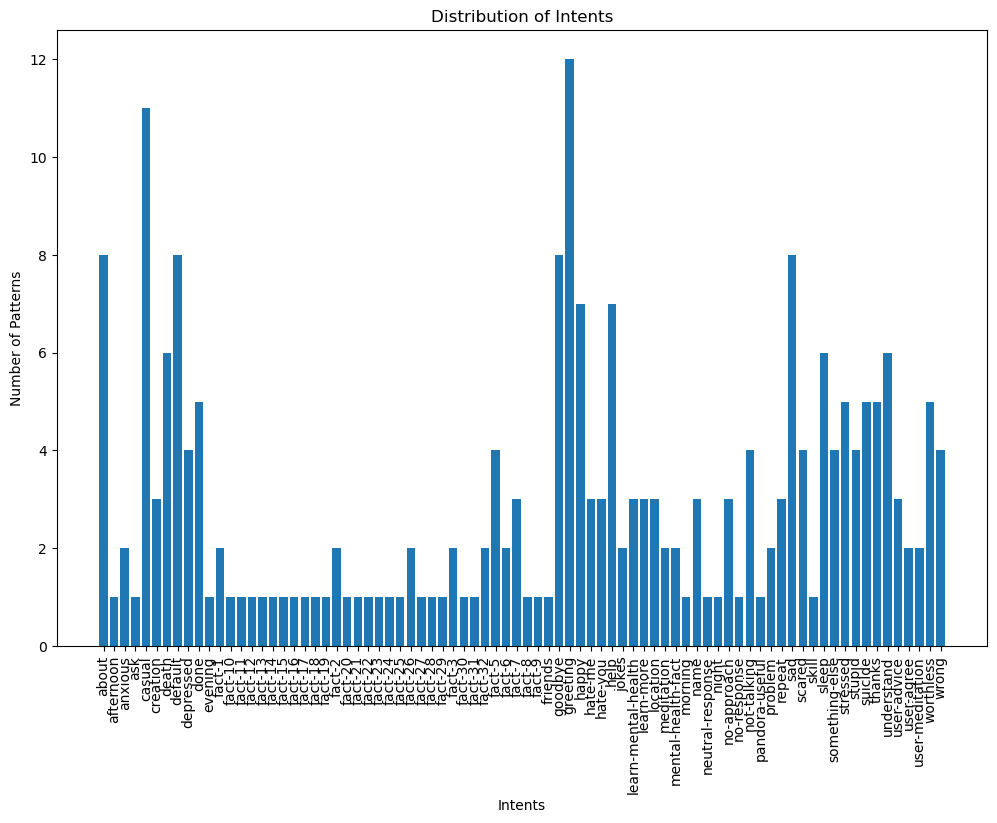

Epoch 1/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.0100 - loss: 4.3708
Epoch 2/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0292 - loss: 4.2267
Epoch 3/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0392 - loss: 4.0521
Epoch 4/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0482 - loss: 3.9676
Epoch 5/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0468 - loss: 3.9095
Epoch 6/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0593 - loss: 3.7276
Epoch 7/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0642 - loss: 3.7330
Epoch 8/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0539 - loss: 3.6020
Epoch 9/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1072 - loss: 3.3986
Epoch 10/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0965 - loss: 3.3319
Epoch 11/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1009 - loss: 3.1610
Epoch 12/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy:

Model trained and saved


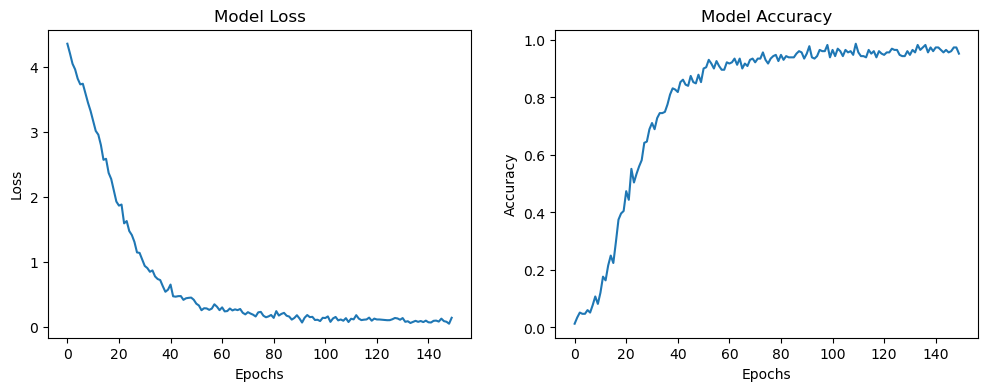

Chatbot is running. Type 'quit' to stop.


You:  good morning


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
Chatbot: /ask.herts.ac.uk/browse/student-community/housing-and-accomodation


In [ ]:
import json
import numpy as np
import random
import nltk
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Load the intents file
with open('intents.json') as file:
    data = json.load(file)

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Preprocess the data
def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens if w not in stop_words and w.isalnum()]
    return " ".join(tokens)

words = []
classes = []
documents = []

for intent in data['intents']:
    for pattern in intent['patterns']:
        pattern = preprocess_text(pattern)
        words.extend(pattern.split())
        documents.append((pattern, intent['tag']))
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

words = sorted(set(words))
classes = sorted(set(classes))

print("Classes:", classes)

# Visualize the distribution of intents
intent_counts = {intent: 0 for intent in classes}
for doc in documents:
    intent_counts[doc[1]] += 1

plt.figure(figsize=(12, 8))
plt.bar(intent_counts.keys(), intent_counts.values())
plt.title('Distribution of Intents')
plt.xlabel('Intents')
plt.ylabel('Number of Patterns')
plt.xticks(rotation=90)
plt.show()

# Create training data
training_sentences = []
training_labels = []

for doc in documents:
    training_sentences.append(doc[0])
    training_labels.append(classes.index(doc[1]))

# Tokenize the data
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(training_sentences)
X_train = tokenizer.texts_to_sequences(training_sentences)
X_train = pad_sequences(X_train)

y_train = np.array(training_labels)

# Build the model
model = Sequential()
model.add(Embedding(input_dim=2000, output_dim=128, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=150, batch_size=5, verbose=1)
model.save('chatbot_model.h5')

print("Model trained and saved")

# Visualize the training process
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

# Load the model
model = tf.keras.models.load_model('chatbot_model.h5')

# Function to preprocess user input
def preprocess_user_input(sentence):
    sentence = preprocess_text(sentence)
    seq = tokenizer.texts_to_sequences([sentence])
    padded = pad_sequences(seq, maxlen=X_train.shape[1])
    return padded

# Function to predict the class
def predict_class(sentence, model):
    padded = preprocess_user_input(sentence)
    res = model.predict(padded)[0]
    ERROR_THRESHOLD = 0.5  # Increased threshold for higher confidence
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list

# Function to get a response
def get_response(ints, intents_json, context):
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if i['tag'] == tag:
            if 'context_set' in i:
                context['set'] = i['context_set']
            if not 'context_filter' in i or (context.get('set') and 'context_filter' in i and i['context_filter'] == context['set']):
                result = random.choice(i['responses'])
                break
    return result

# Main function to interact with the chatbot
def chatbot_response(msg, context):
    ints = predict_class(msg, model)
    if ints:
        res = get_response(ints, data, context)
    else:
        res = random.choice(["I'm not sure how to respond to that.", "Can you please rephrase that?", "I didn't understand that, could you clarify?"])
    return res

# Interactive interface
def chat():
    print("Chatbot is running. Type 'quit' to stop.")
    context = {}
    while True:
        message = input("You: ")
        if message.lower() == "quit":
            break
        response = chatbot_response(message, context)
        print(f"Chatbot: {response}")

# Start chat
if __name__ == "__main__":
    chat()
